# PyTorch Computer Vision with Pre-trained Models and Custom Dataset

In [1]:
# import sys
# from google.colab import drive
# drive.mount('/content/drive')

# project_dir = "/content/drive/MyDrive/Colab Notebooks/pizza-sushi-steak"
# sys.path.insert(0, project_dir)
# !pip install torchinfo torcheval

## 1. Import Libraries

In [2]:
import random
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, transforms, models

from torch.utils.data import DataLoader
from torchinfo import summary
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
)
from mlxtend.plotting import plot_confusion_matrix

import engine
import utils

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

RAMDOM_SEED = 42

%load_ext autoreload
%autoreload 2

torch: 2.2.0
torchvision: 0.17.0
device: cpu


## 2. Get Dataset

### 2.1 Downloading dataset from url

In [3]:
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_dir = "pizza_steak_sushi"
image_dir = utils.download_dataset_from_url(url, data_dir)

# image_dir = project_dir + "/data/pizza_steak_sushi"
# image_dir = Path(image_dir)
# image_dir

data/pizza_steak_sushi directory exists.


### 2.2 Creating directories

In [4]:
train_dir = image_dir / "train"
test_dir = image_dir / "test"
image_path_list = list(image_dir.glob("*/*/*.jpg"))

print(f"image directory : {image_dir}")
print(f"train directory : {train_dir}")
print(f"test  directory : {test_dir}")
print(f"number of all images : {len(image_path_list)}")

image directory : data/pizza_steak_sushi
train directory : data/pizza_steak_sushi/train
test  directory : data/pizza_steak_sushi/test
number of all images : 300


### 2.3 Visualizing the raw images

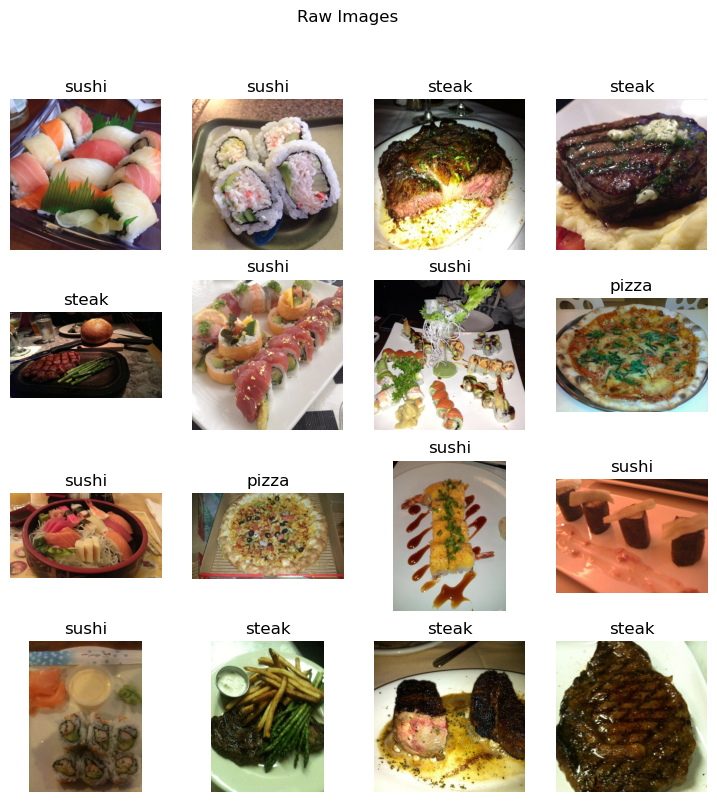

In [5]:
random.seed(RAMDOM_SEED)

rows, cols = 4, 4
random_image_paths = random.sample(image_path_list, k=rows*cols)

fig = plt.figure(figsize=(9, 9))
plt.suptitle("Raw Images")
plt.axis(False)
for i, image_path in enumerate(random_image_paths, start=1):
    label = image_path.parent.stem
    ax = fig.add_subplot(rows, cols, i)
    with Image.open(image_path) as img:
        plt.imshow(img)
    ax.set_title(label)
    ax.axis(False)

## 3. Model_0: Using `ResNet50` pre-trained model

### 3.1 Downloading model

In [6]:
## Will download about 100 MB
weights = models.ResNet50_Weights.DEFAULT
preprocess = weights.transforms(antialias=True)
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
model_0 = models.resnet50(weights=weights)
model_0.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
summary(
    model_0,
    input_size=(1, 3, 224, 224), # (batch_size, color_channel, height, weight)
    col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
ResNet                                   [1, 3, 224, 224]          [1, 1000]                 --                        --                        True
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    True
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        True
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3                         --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 256, 56, 56]          --    

### 3.2 Creating `train_data` and `test_data`

In [9]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=preprocess,
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=preprocess,
)

In [10]:
print(f"train data: {len(train_data)}")
print(f"test data : {len(test_data)}")

class_names = train_data.classes
NUM_CLASSES = len(class_names)
print(f"number of classes: {NUM_CLASSES}")
print(f"\nclass names:\n{class_names}")

class_to_idx = train_data.class_to_idx
print(f"\nclass to index:\n{class_to_idx}")

targets = train_data.targets
print(f"\nlength of targets:\n{len(targets)}")

image, label = train_data[0]
INPUT_IMAGE_SIZE = image.shape
print(f"\nimage shape:\n{INPUT_IMAGE_SIZE} -> [color_channels, height, width]")
print(f"\nimage index label:\n{label}")
print(f"\nimage label:\n{class_names[label]}")

train data: 225
test data : 75
number of classes: 3

class names:
['pizza', 'steak', 'sushi']

class to index:
{'pizza': 0, 'steak': 1, 'sushi': 2}

length of targets:
225

image shape:
torch.Size([3, 224, 224]) -> [color_channels, height, width]

image index label:
0

image label:
pizza


### 3.3 Using `DataLoader()` to turn `train_data` and `test_data` into batches.

In [11]:
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"train dataloader: {train_dataloader}")
print(f"test Dataloader : {test_dataloader}")
print(f"length of train dataloader: {len(train_dataloader)} batches of \
{BATCH_SIZE} ({len(train_dataloader)*BATCH_SIZE})")
print(f"length of test dataloader : {len(test_dataloader)} batches of \
{BATCH_SIZE} ({len(test_dataloader)*BATCH_SIZE})")

Creating DataLoader's with batch size 8 and 4 workers.
train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f2bf11fbaf0>
test Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x7f2bf11facb0>
length of train dataloader: 29 batches of 8 (232)
length of test dataloader : 10 batches of 8 (80)


### 3.4 Creating feature extraction model from `ResNet50`

In [12]:
for param in model_0.parameters():
    param.requires_grad = False

# Number of features in the bottleneck layer
num_ftrs = model_0.fc.in_features

torch.manual_seed(RAMDOM_SEED)
torch.cuda.manual_seed(RAMDOM_SEED)

# Parameters of newly constructed modules have requires_grad=True by default
model_0.fc = nn.Linear(num_ftrs, NUM_CLASSES)

summary(
    model_0,
    input_size=(1, 3, 224, 224), # (batch_size, color_channel, height, weight)
    col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
ResNet                                   [1, 3, 224, 224]          [1, 3]                    --                        --                        Partial
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         (9,408)                   [7, 7]                    False
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         (128)                     --                        False
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3                         --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 256, 56, 56]          -

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
activation_fn = lambda x: torch.argmax(x, dim=1)

### 3.5 Train the model or load pre-trained state_dict

based of what machine you are working modify this argument:
`map_location=torch.device('cpu')`

In [15]:
model_0.load_state_dict(torch.load(f="./models/model_0.pth", map_location=torch.device('cpu')))
model_0_results = utils.load_model_results("./models/model_0.json")

In [ ]:
# model_0_results = engine.train(
#     epochs=2,
#     model=model_0,
#     train_dataloader=train_dataloader,
#     test_dataloader=test_dataloader,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     activation_fn=activation_fn,
#     accuracy_fn=multiclass_accuracy,
#     device=device,
# )

### 3.6 Plot loss and accuracy curves

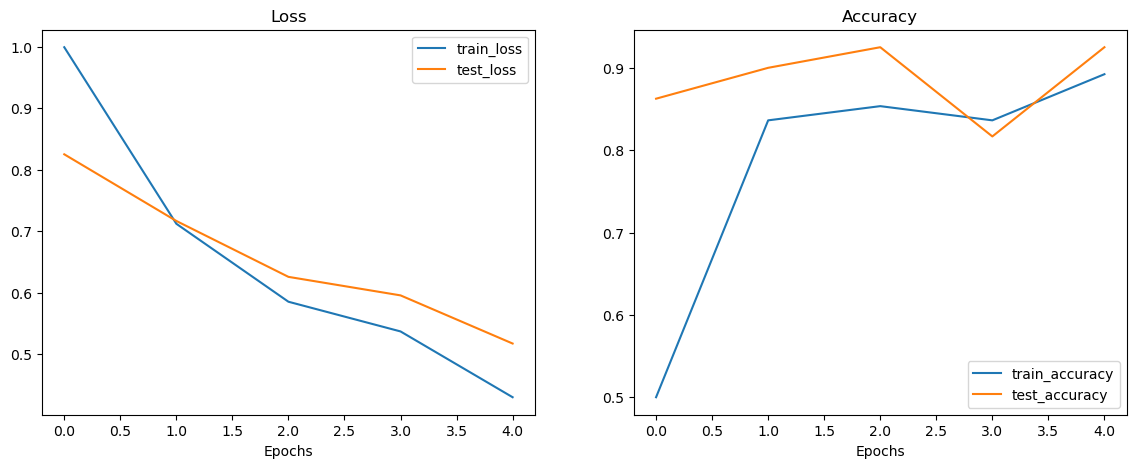

In [16]:
utils.plot_loss_curves(model_0_results, figsize=(14, 5))

### 4.4 Make predictions and get model_0 results


In [17]:
model_0_result = engine.test_step(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    activation_fn=activation_fn,
    accuracy_fn=multiclass_accuracy,
    device=device,
)
model_name = model_0.__class__.__name__
model_loss = model_0_result[0]
model_accuracy = model_0_result[1]
print(f"Results for {model_name}:")
print(f"loss = {model_loss:.3f}, accuracy = {model_accuracy:.3f}")

Results for ResNet:
loss = 0.519, accuracy = 0.925


### 4.5 Saving the model


In [18]:
utils.save_model(
    model=model_0,
    target_dir="models",
    model_name="model_0.pth",
    results=model_0_results,
)

[INFO] Saving model to: models/model_0.pth
[INFO] Saving training results to: models/model_0.json


### 4.6 Make and evaluate random predictions


#### 4.6.1 Create samples from data


In [19]:
samples, lables = utils.create_samples(
    data=test_data, num_samples=9, random_seed=RAMDOM_SEED
)
lables

[0, 0, 1, 1, 1, 0, 0, 0, 2]

#### 4.6.2 Make predictions


In [20]:
pred_labels = utils.make_predictions(model=model_0, samples=samples, device=device)
pred_labels

[0, 0, 1, 1, 1, 0, 0, 0, 2]

#### 4.6.3 Plot predictions


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


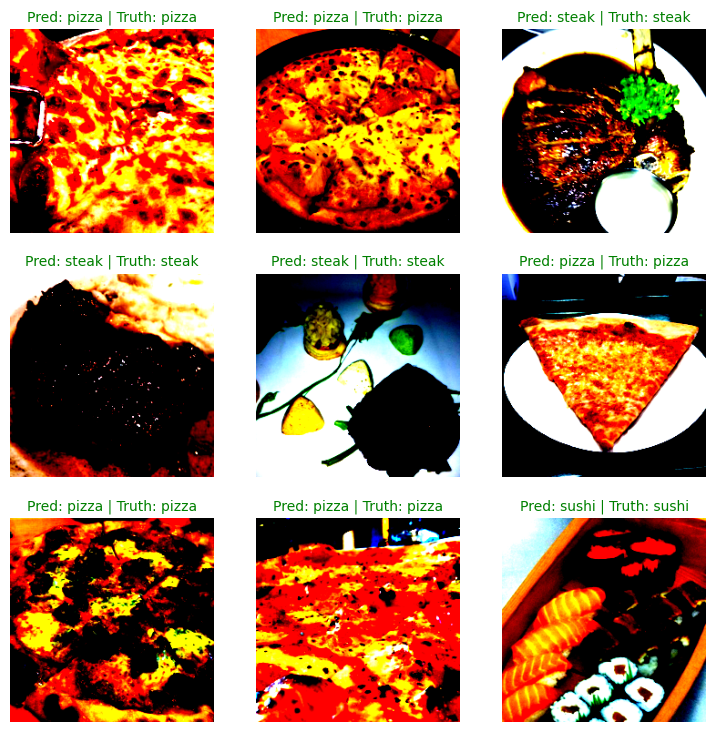

In [21]:
utils.plot_predictions(
    samples=samples,
    lables=lables,
    pred_labels=pred_labels,
    class_names=class_names,
)

### 4.7 Evaluation with confusion matrix


In [22]:
y_preds = engine.evaluation_step(
    model=model_0,
    data_loader=test_dataloader,
    activation_fn=activation_fn,
    device=device,
)


Making predictions:   0%|          | 0/10 [00:00<?, ?it/s]

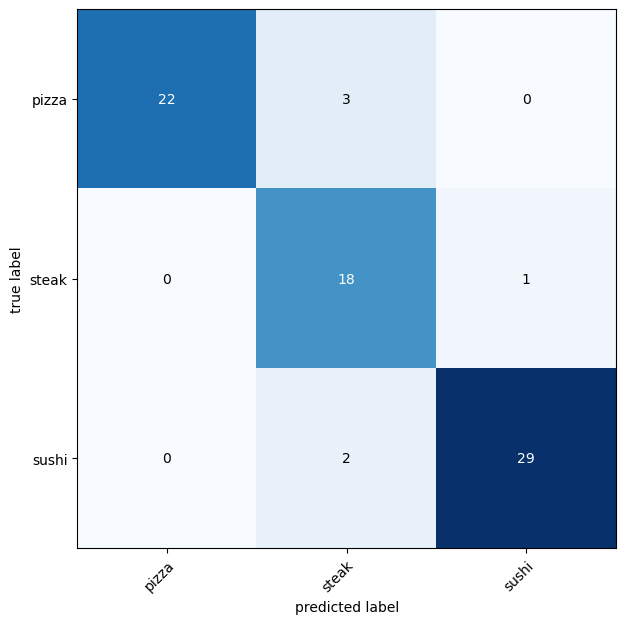

In [23]:
cm = multiclass_confusion_matrix(
    input=y_preds,
    target=torch.tensor(test_data.targets),
    num_classes=NUM_CLASSES,
)
fig, ax = plot_confusion_matrix(cm.numpy(), class_names=class_names, figsize=(10, 7))

### 4.8 Predict new images

In [75]:
images_dir = Path("./images")
image_paths = []
for dirpath, _, filenames in os.walk(images_dir):
    dirpath = Path(dirpath)
    for filename in filenames:
        image_paths.append(dirpath / filename)
print(image_paths)

[PosixPath('images/steak.jpg'), PosixPath('images/sushi.jpg'), PosixPath('images/pizza.jpg')]


In [76]:
new_samples = []
new_pred_labels = []
for image_path in image_paths:
    custom_image = torchvision.io.read_image(str(image_path))
    new_samples.append(custom_image)

    transformed_img = preprocess(custom_image).unsqueeze(dim=0)
    with torch.inference_mode():
        prediction_logist = model_0(transformed_img)
    prediction_index = activation_fn(prediction_logist)
    new_pred_labels.append(prediction_index)


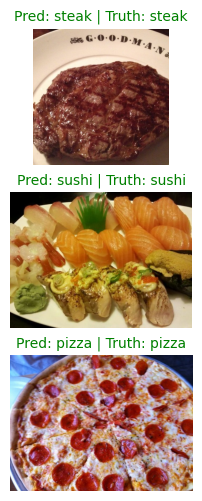

In [77]:
utils.plot_predictions(
    samples=new_samples,
    lables=[1, 2, 0],
    pred_labels=new_pred_labels,
    class_names=class_names,
    nrows=3,
    ncols=1,
    figsize=(6, 6),
)